In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi
import scipy
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

Proper rectangle shape

In [29]:
def solve_eigenproblem_rectangle(parameters, energy = 1e-6, number_of_bands = int(1),plot_shape = True):
    Nx = parameters['Nx']     # Number of unit cells in x direction
    Ny = parameters['Ny']     # Number of unit cells in y direction
   
    if plot_shape:
        Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_rectangle(parameters, return_shape = True)
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111)
        ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
        ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
        ax.set_aspect('equal')
        fig.show()
    else:
        Phi, H, P, deleted_indices = operators_rectangle(parameters, return_shape = False)

      #Solve generalised eigenproblem
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-6, sigma = energy, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    ##### This following part is specific for the rectangle ######
    edge_points, normal_angles = generate_rectangle(Nx-2, Ny-2)
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
      # Now rotate back the spins on the edge
    theta = parameters['theta']
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]+pi)
        states = rotation@states

    ###Now reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Now assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0 #This should be zero
        else:
            energies[i] = eigenvalues[i]
    
    return energies, states_shaped, degenerate_indices

In [30]:
def operators_rectangle(parameters, return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = 0    # open system
    ky = 0    # open system
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
                
        #Phases
        phase_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        phase_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
       
    mass = scipy.sparse.spdiags(parameters['mass']*np.ones(Nx*Ny), 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@M@Phi
        
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_rectangle(Nx-2, Ny-2)
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    indices_to_delete = []
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    Lx = Nx-2
    Ly = Ny-2
    def discriminant(x,y):
        return x>1 and x<Lx+1 and y>1 and y<Ly+1
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if not discriminant(x,y) and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [31]:
def generate_rectangle(Lx, Ly, plot_shape = False):
    'Generates the set of points in the grid closest to a rectangle with sides Nx and Nx and the angle of the normal vector.'

    x1 = Lx*np.ones(Ly-1)
    y1 = np.linspace(1,Ly, Ly-1, endpoint=False)
    angles1 = np.zeros(Ly-1)
    x2 = np.linspace(Lx-1,0, Lx-1, endpoint = False)
    y2 = Ly*np.ones(Lx-1)
    angles2 = (pi/2)*np.ones(Lx-1)
    
    x3 = np.zeros(Ly-1)
    y3 = np.linspace(Ly-1,0, Ly-1, endpoint=False)
    angles3 = pi*np.ones(Ly-1)
    x4 = np.linspace(1,Lx, Lx-1, endpoint = False)
    y4 = np.zeros(Lx-1)
    angles4 = -(pi/2)*np.ones(Lx-1)

    x = np.concatenate((x1,x2,x3,x4))
    y = np.concatenate((y1,y2,y3,y4))

    
    normal_angles = np.concatenate((angles1,angles2,angles3,angles4))
    boundary_points = np.stack((x,y)) + np.array([[1]*(len(normal_angles)),[1]*(len(normal_angles))])


    # Now the points inside 
    Nx = parameters['Nx']
    Ny = parameters['Ny']
    
    def discriminant(x,y):
        return x>1 and x<Lx+1 and y>1 and y<Ly+1
    
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)
    
    indices_to_delete = []    
    for point in zip(boundary_points[0], boundary_points[1]):
        #book index to delete from the edges
        indices_to_delete.append(get_index(point[0],point[1],1))
    amount_out = 0
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if not discriminant(x,y) and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
    
    inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
    inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
    inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
    inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
    spinup_shape = (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:])
    spindown_shape = (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])

    ##Plot shape

    if plot_shape:

        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111)
        #ax.scatter(spinup_shape[0],spinup_shape[1], s = 10)
        ax.scatter(spindown_shape[0],spindown_shape[1], s = 10,zorder=-1)
        ax.scatter(boundary_points[0],boundary_points[1], s = 4)
        ax.set_aspect('equal')
    
        return boundary_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete

    
    return boundary_points, normal_angles

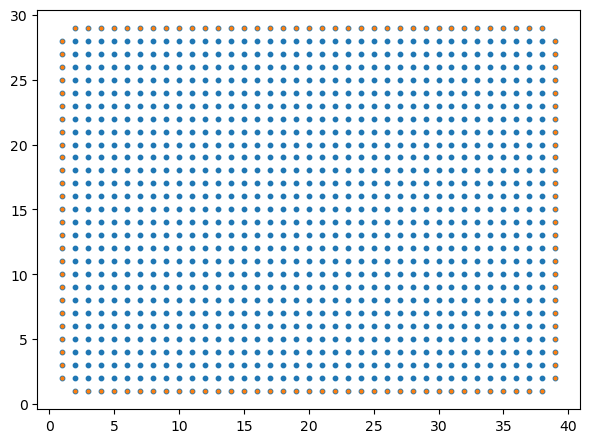

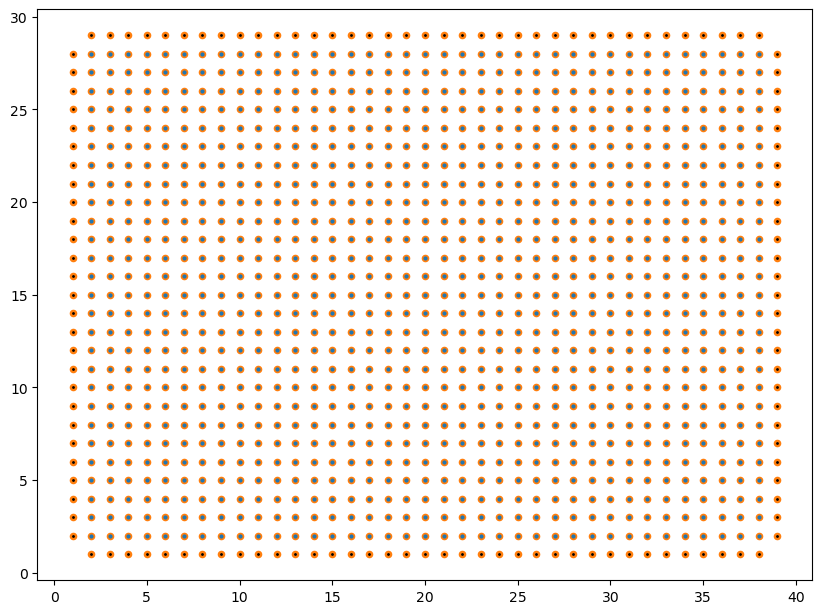

In [5]:
Nx = 40
Ny = 30

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    theta = -(pi/2)*(0/100),
)


boundary_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete = generate_rectangle(Nx-2,Ny-2, plot_shape = True)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.scatter(spinup_shape[0],spinup_shape[1], s = 4)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
ax.scatter(boundary_points[0],boundary_points[1], s = 1,c = 'k')
#ax.scatter(boundary_points[0],boundary_points[1], s = 4)
ax.set_aspect('equal')

## Solve the generalised eigenvalue problem for the desired boundary conditions in a square geometry.

In [32]:
i = 0
Nx = 20 #Assume translational invariance in x direction
Ny = 20
nbands = int((Nx*Ny)/100)
print('Bands to calculate: ',nbands)
mass=0.1

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    mass = mass,
    theta = -(pi/2)*(i/100),
)

Bands to calculate:  4


/tmp/ipykernel_39580/3954259386.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


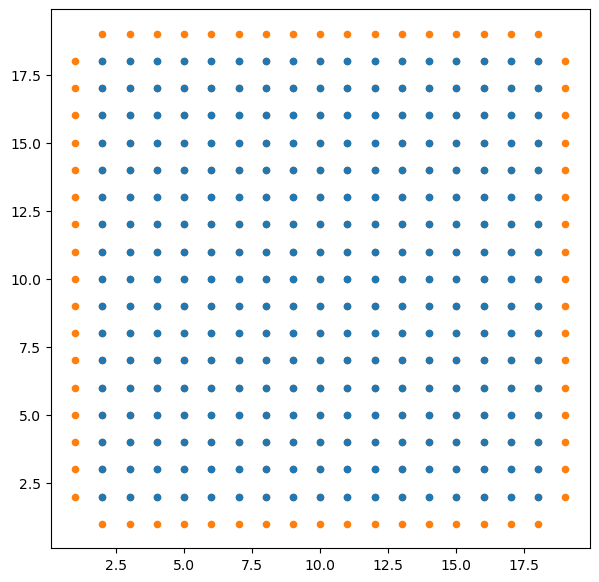

In [34]:
ener, states, degenerate_indices = solve_eigenproblem_rectangle(parameters, number_of_bands = nbands, plot_shape=True)

/tmp/ipykernel_39178/2725401766.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


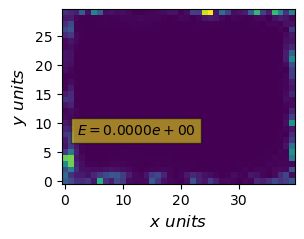

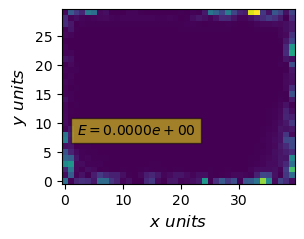

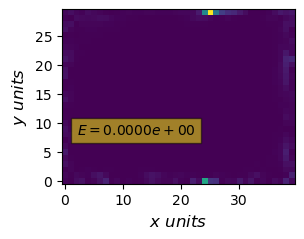

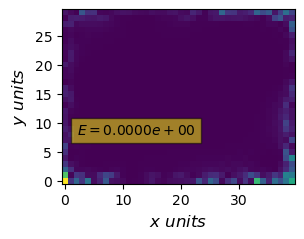

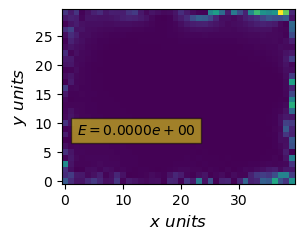

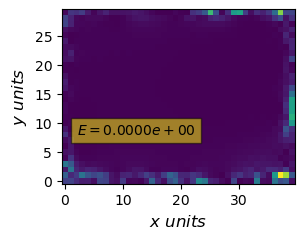

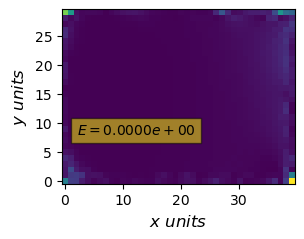

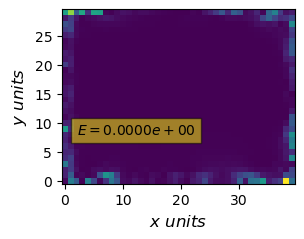

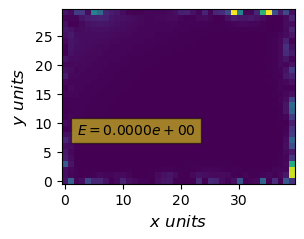

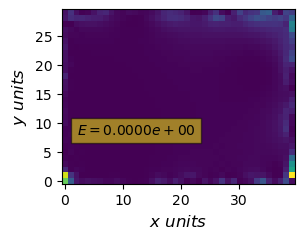

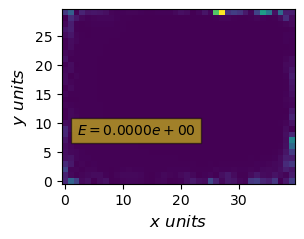

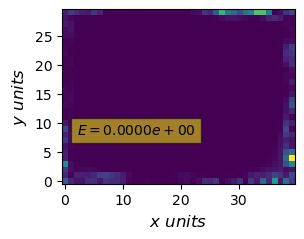

In [29]:
for i in range(nbands):
    to_plot = states[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0, origin = "lower")
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{ener[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)
    
    
    fig.show()

Text(0.5, 0, '$r$ $units$')

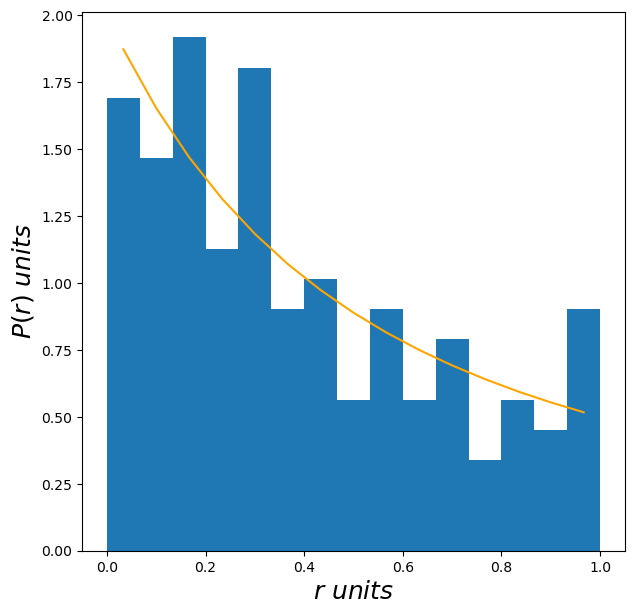

In [5]:
def spacing_ratios_distribution(spectrum, nbins = 41):
    
    spacings = (np.sort(spectrum)-np.roll(np.sort(spectrum),1))[1:]
    ratios = (spacings/np.roll(spacings,1))[1:]
    ratios = np.where(ratios<1, ratios, 1/ratios)
    histogram, bin_edges = np.histogram(ratios, range = (0,1), bins = nbins, density = True )
    
    return histogram, bin_edges

nbins_spacing = 15
#ratios_distribution, bin_edges = spacing_ratios_distribution(spectrum_, nbins = nbins_spacing)

ratios_distribution, bin_edges = spacing_ratios_distribution(ener[:len(ener)], nbins = nbins_spacing)

x = (bin_edges[1:]+bin_edges[:-1])/2
dx = (bin_edges[1]-bin_edges[0])
analytical = 2/(1+x)**2

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.bar(x,ratios_distribution,width = dx)
ax.plot(x,analytical, c = 'orange')
ax.set_ylabel(r"$P(r)$ $units$",fontsize = 18)
ax.set_xlabel(r"$r$ $units$",fontsize = 18)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi

path = '/home/donisvelaa/data1/tangent-boundaries/'

thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

i = -1 ### selected value of theta
Nx = 43
Ny = 43
#nbands = int((Nx*Ny)/100*16)
nbands = 5
print('Bands to calculate: ',nbands)

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    B1 = 0, # no magnetic field
    N1 = 0, #
    d1 = 0, # These are irrelevant for B1 = 0
    N2 = 0, #
    potential = lambda x,y:0.0*np.random.rand(Ny,Nx),
    mass = lambda x,y:0*x,
    disorder = 0,
    theta = -(pi/2)*(thetas[i]/100),
)

# ################## SQUARE
print('Solving square')
print('theta/(pi/2) = ', thetas[i])
print('Nx = ', parameters['Nx'])
print('Ny = ', parameters['Ny'])
spectrum_square, states_square, degenerate_indices_square = tb.solve_eigenproblem_square(parameters, number_of_bands = nbands, plot_shape = False)

# path = '/home/donisvelaa/data1/tangent-boundaries/'

# print('Saving square spectrum')
# name = 'square_spectrum_sym'
# np.save(path+name+'_Nx'+str(Nx)+'_Ny'+str(Ny)+'_theta'+str(thetas[i])+'_nbands'+str(nbands), spectrum_square, allow_pickle=True)
# print('Saving square eigenstates')
# name = 'square_states_sym'
# np.save(path+name+'_Nx'+str(Nx)+'_Ny'+str(Ny)+'_theta'+str(thetas[i])+'_nbands'+str(nbands), states_square, allow_pickle=True)

Bands to calculate:  5
Solving square
theta/(pi/2) =  100
Nx =  43
Ny =  43


/tmp/ipykernel_25207/1186533976.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


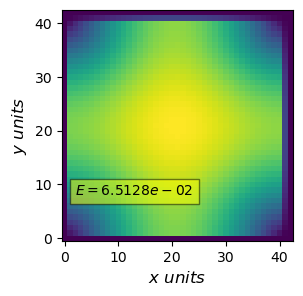

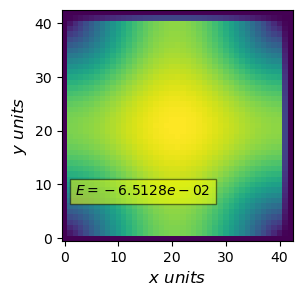

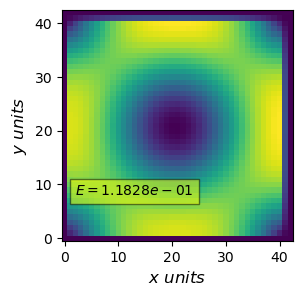

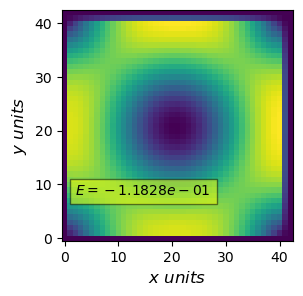

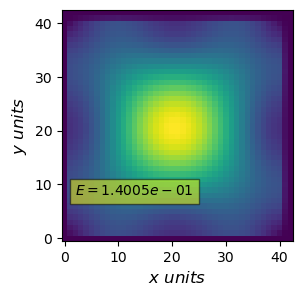

In [2]:
for i in range(nbands):
    to_plot = states_square[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0, origin = "lower")
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{spectrum_square[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)
    
    
    fig.show()